# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate

## The Dice problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided
die, an 8-sided die, a 12-sided die, and a 20-sided die.

I select a die from the box at random, roll it, and get a 6.
What is the probability that I rolled each die?

In [4]:
hypos = [4, 6, 8, 12, 20]
prior = Pmf(1, hypos)
prior

,probs
4,1
6,1
8,1
12,1
20,1


In [5]:
likelihood = 0, 1/6, 1/8, 1/12, 1/20
unnorm = prior * likelihood
prob_data = unnorm.sum()
prob_data

0.42499999999999993

In [6]:
posterior = unnorm / prob_data
posterior

,probs
4,0.000000
6,0.392157
8,0.294118
12,0.196078
20,0.117647


In [7]:
def likelihood_dice(data, hypos):
    like = np.array(1 / hypos)
    like[data > hypos] = 0
    return like

In [8]:
likelihood_dice(6, prior.qs)

array([0.        , 0.16666667, 0.125     , 0.08333333, 0.05      ])

And here's what it looks like after more data:

In [9]:
def update_dice(pmf, data):    
    like = likelihood_dice(data, prior.qs)
    pmf *= likelihood
    pmf /= pmf.sum()
    return pmf

In [10]:
pmf = prior.copy()

for roll in [6, 8, 7, 7, 5, 4]:
    update_dice(pmf, roll)
        
pmf

,probs
4,0.000000
6,0.837288
8,0.149019
12,0.013083
20,0.000610


## The train problem

The Train problem has the same likelihood as the Dice problem.

In [11]:
hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

In [12]:
def likelihood_train(data, hypos):
    like = np.array(1 / hypos)
    like[data > hypos] = 0
    return like

But there are many more hypotheses

In [13]:
likelihood = likelihood_train(37, hypos)
posterior = prior * likelihood
posterior.normalize()

3.310911663755706

Here's what the posterior looks like

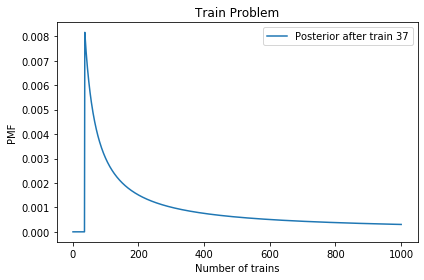

In [14]:
posterior.plot(label='Posterior after train 37')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Train Problem')

And here's how we can compute the posterior mean

In [15]:
np.sum(posterior.ps * posterior.qs)

291.15847775488356

Or we can just use the method

In [16]:
posterior.mean()

291.15847775488356

## Sensitivity to the prior

Here's a function that solves the train problem for different priors and data

In [17]:
def update_train(pmf, dataset):
    """Solves the train problem.
    
    pmf: 
    dataset: sequence of observed train numbers
    
    returns: Pmf representing the posterior distribution
    """
    for data in dataset:
        pmf *= likelihood_train(data, hypos)

    pmf.normalize()

Let's run it with the same dataset and several uniform priors

In [18]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, dataset)
    print(high, pmf.mean())

500 151.84958795903836
1000 164.30558642273346
2000 171.3381810915096


The results are quite sensitive to the prior, even with several observations.

## Power law prior

Now let's try it with a power law prior.

In [19]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

In [20]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

7.485470860550345

Here's what a power law prior looks like, compared to a uniform prior

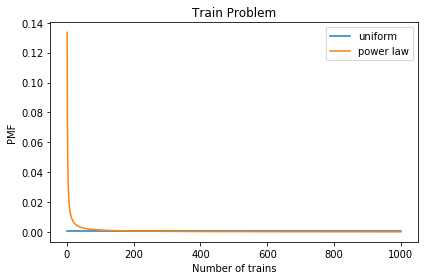

In [21]:
uniform.plot()
power.plot()

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Train Problem')

Now let's see what the posteriors look like after observing one train.

In [22]:
dataset = [60]

update_train(uniform, dataset)
update_train(power, dataset)

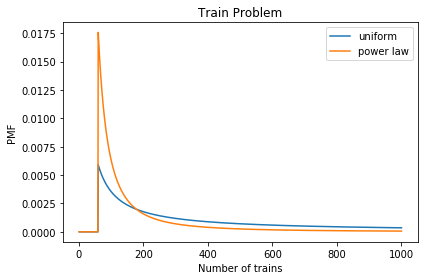

In [23]:
uniform.plot()
power.plot()

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Train Problem')

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

In [24]:
alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos, name='power law')
    update_train(power, dataset)
    print(high, power.mean())

500 130.70846986255992
1000 133.27523137503107
2000 133.99746308073125


## Credible intervals

To compute credible intervals, we can use the `quantile` method on the posterior.

In [25]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos)
update_train(uniform, dataset)

uniform.quantile([0.5, 0.95])

array([126., 373.])

## Exercises

**Exercise:** To write a likelihood function for the locomotive problem, we had
to answer this question:  "If the railroad has `N` locomotives, what
is the probability that we see number 60?"

The answer depends on what sampling process we use when we observe the
locomotive.  In the book, I resolved the ambiguity by specifying
that there is only one train-operating company (or only one that we
care about).

But suppose instead that there are many companies with different
numbers of trains.  And suppose that you are equally likely to see any
train operated by any company.
In that case, the likelihood function is different because you
are more likely to see a train operated by a large company.

As an exercise, implement the likelihood function for this variation
of the locomotive problem, and compare the results.

In [26]:
# Solution

# Suppose Company A has N trains and all other companies have M.
# The chance that we would observe one of Company A's trains is 
# $N/(N+M)$.

# Given that we observe one of Company A's trains, the chance that we
# observe number 60 is $1/N$ for $N \ge 60$.

# The product of these probabilities is $1/(N+M)$, which is the
# probability of observing any given train.

# If N<<M, this converges to a constant, which means that all values
# of $N$ have the same likelihood, so we learn nothing about how many 
# trains Company A has.

# If N>>M, this converges to $1/N$, which is what we saw in the 
# previous solution.

# More generally, if M is unknown, we would need a prior distribution 
# for M, then we can do a two-dimensional update, and then extract the posterior
# distribution for N.

# We'll see how to do that soon.